In [1]:
%%time
%matplotlib inline

import importlib
import new_import_ODC  

importlib.reload(new_import_ODC)

from new_import_ODC import *

CPU times: user 13.9 s, sys: 4.07 s, total: 18 s
Wall time: 11.6 s


In [2]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
dc = datacube.Datacube()

# Configure s3 access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

client

Starting new cluster.
CPU times: user 786 ms, sys: 34.1 ms, total: 820 ms
Wall time: 4min 1s


<Client: 'tls://10.0.49.171:8786' processes=0 threads=0, memory=0 B>

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/env/lib/python3.10/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/usr/lib/python3.10/ssl.py", line 1371, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1007)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "/env/lib/python3.10/site-packages/tornado/iostream.py", line 691, in _handle_events
    self._handle_read()
  File "/env/lib/python3.10/site-packages/tornado/iostream.py", line 1427, in _handle_r

In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

In [4]:
## truy vấn ảnh vệ tinh sen2
data = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset> Size: 310MB
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 624B 2022-09-02T03:35:38.706000 ... 20...
  * y            (y) float64 4kB 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 7kB 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 4B 32648
Data variables:
    red          (time, y, x) float32 138MB dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 138MB dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 34MB dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_clean(data)
progress(result)

bits  \
qa  [0, 1, 2, 3, 4, 5, 6, 7]   

                                               values  \
qa  {'0': 'no data', '1': 'saturated or defective'...   

                     description  
qa  Sen2Cor Scene Classification

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 92.3 ms, sys: 3.78 ms, total: 96.1 ms
Wall time: 94.4 ms


VBox()

In [6]:
# Tiến hành tính toán NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 78, y: 532, x: 830)> Size: 138MB
dask.array<truediv, shape=(78, 532, 830), dtype=float32, chunksize=(1, 532, 830), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 624B 2022-09-02T03:35:38.706000 ... 20...
  * y            (y) float64 4kB 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 7kB 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 4B 32648

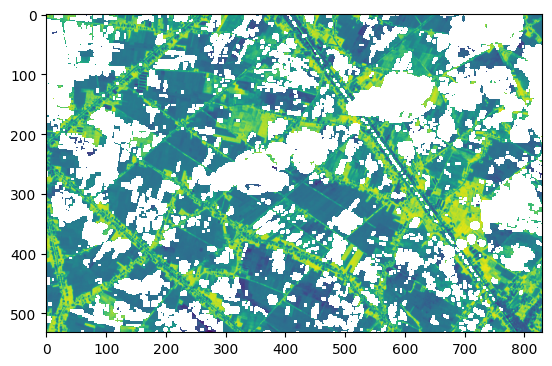

In [7]:
## ảnh ndvi chưa fill nan
plt.imshow(ndvi.isel(time=50))

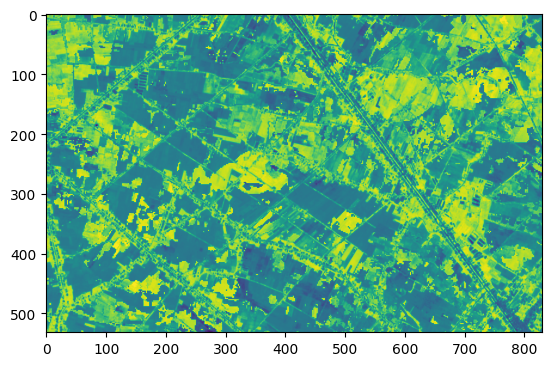

In [8]:
# đặt thời gian các mùa
time_split = [slice('2022-09-01', '2023-01-01'), 
               slice('2023-01-01', '2023-05-01'),
               slice('2023-05-01', '2023-07-01'),
               slice('2023-07-01', '2023-10-01')]

# Điền mây ở các vị trí mang giá trị nan (fill nan)
fill_nan_ndvi = fill_nan(ndvi, time_split)

# In kết quả ảnh ndvi đã điền mây (đã fill nan)
plt.imshow(fill_nan_ndvi.isel(time=50))

In [9]:
%%time
## tính ndvi theo tháng
average_ndvi = fill_nan_ndvi.resample(time='1M').mean().persist()
progress(average_ndvi)

CPU times: user 153 ms, sys: 9.02 ms, total: 162 ms
Wall time: 161 ms


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


VBox()

In [10]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

In [11]:
# load dữ liệu sen1
coordinates = (longtitude_range, latitude_range)
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)
average_vv = calculate_average(dsvv, time_pattern='1M')
average_vh = calculate_average(dsvh, time_pattern='1M')

<xarray.Dataset> Size: 113MB
Dimensions:      (time: 32, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 256B 2022-09-06T22:46:14.500000 ... 20...
  * y            (y) float64 4kB 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 7kB 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 4B 32648
Data variables:
    vv           (time, y, x) float32 57MB dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    vh           (time, y, x) float32 57MB dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.
<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


In [12]:
# load model RF
loaded_model = joblib.load(os.path.join("model_train", "model_odc.joblib"))

# dự đoán
data_array = predict(loaded_model, data.rio.crs, average_ndvi, average_vh, average_vv)

/tmp/ipykernel_145/3809256623.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


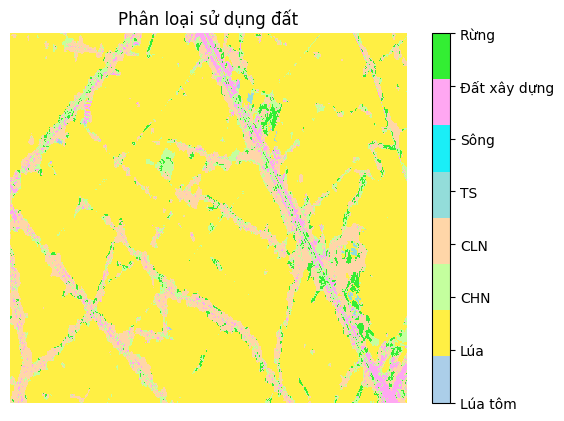

In [13]:
# cấu hình màu cho các loại đất
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [14]:
## cấu hình shapefile ranh giới thuận hòa và vh vv file
thuanhoa_path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"

# cắt theo ranh giới xã thuận hòa
region_result = cut_according_shp(thuanhoa_path, average_ndvi, data_array)

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [15]:
# hiển thị kết quả phân loại sử dụng đất
colorval = list(range(len(colors)))
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
region_result.hvplot(
    rasterize = True,                        # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   []
   :Image   [x,y]   (value)

In [16]:
# Lưu lại kết quả
region_result.rio.to_raster("KetQuaPhanLoaiDatODC.tif")

In [22]:
# Load dữ liệu test
test_path = "ThuanHoa/DataTest/ThuanHoa_DKS_Kappa.shp"  # đường dẫn shp file train
test = load_train_data(test_path)
test.head()

# đánh giá độ chính xác
accuracy_test(test, data_array)

độ chính xác: 42.81%


In [ ]:
# đóng client, cluster
client.close()
cluster.close()